In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

try:
    df = pd.read_csv('df_engineered.csv')
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    print("Error: 'df_engineered.csv' not found. Please check the file path.")
    df = pd.DataFrame()

if not df.empty:
    print(df.head())

Dataset loaded successfully.
Shape of the dataset: (7914, 66)
                             titulo     tipo_de_producto              serie  \
0     Apple MacBook Air 13" 2024 M3  Portátil multimedia  Apple MacBook Air   
1     Apple MacBook Air 15" 2024 M3  Portátil multimedia  Apple MacBook Air   
2   Apple MacBook Pro 14" M4 (2024)  Portátil multimedia  Apple MacBook Pro   
3  ASUS TUF Gaming A15 FA506 (2024)      Portátil gaming    ASUS TUF Gaming   
4         GigaByte Aero 16 OLED BKF      Portátil gaming      Gigabyte Aero   

  pantalla_tecnologia            procesador disco_duro_tipo_de_disco_duro  \
0              Retina              Apple M3                           SSD   
1              Retina              Apple M3                           SSD   
2              Retina               Unknown                           SSD   
3             Full HD               Unknown                           SSD   
4                UHD+  Intel Core i7-13700H                           SSD   



In [2]:
if not df.empty:
    numerical_cols = [
        'procesador_numero_nucleos', 'precio_mean', 'ram_memoria_gb',
        'disco_duro_capacidad_de_memoria_ssd_gb', 'procesador_frecuencia_turbo_max_ghz',
        'medidas_y_peso_profundidad_cm', 'medidas_y_peso_ancho_cm',
        'procesador_cache_mb', 'ram_frecuencia_de_la_memoria_mhz',
        'equip_altavoces_estéreo', 'equip_refrigeración_líquida', 'equip_usb_c'
    ]

    categorical_cols = [
        'tipo_de_producto', 'disco_duro_tipo_de_disco_duro', 'procesador_fabricante',
        'procesador_tipo', 'sistema_operativo_sistema_operativo', 'ram_tipo',
        'custom_category', 'comunicaciones_estandar_lan', 'tipo'
    ]

    features_df = df[numerical_cols + categorical_cols].copy()

    for col in categorical_cols:
        if features_df[col].dtype == 'object':
            features_df[col] = features_df[col].fillna('Missing')

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ], remainder='passthrough')

    try:
        processed_features = preprocessor.fit_transform(features_df)
        print(f"Shape of processed features: {processed_features.shape}")

    except Exception as e:
        print(f"An error occurred during preprocessing: {e}")
        processed_features = None

else:
    print("DataFrame is empty, skipping preprocessing.")
    processed_features = None

Shape of processed features: (7914, 167)


In [3]:
if processed_features is not None and not df.empty:
    chosen_k = 2
    print(f"Performing K-Means clustering with k={chosen_k}...")

    kmeans_k2 = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
    cluster_labels_k2 = kmeans_k2.fit_predict(processed_features)

    df_clustered_k2 = df.copy()
    df_clustered_k2['cluster'] = cluster_labels_k2

    print(f"\nFirst 5 rows of the DataFrame with k={chosen_k} cluster labels:")
    print(df_clustered_k2[['titulo', 'tipo_de_producto', 'precio_mean', 'custom_category', 'cluster']].head())
else:
    print("Processed features not available or DataFrame empty, skipping K-Means clustering.")

Performing K-Means clustering with k=2...

First 5 rows of the DataFrame with k=2 cluster labels:
                             titulo     tipo_de_producto  precio_mean  \
0     Apple MacBook Air 13" 2024 M3  Portátil multimedia      1656.85   
1     Apple MacBook Air 15" 2024 M3  Portátil multimedia      1971.34   
2   Apple MacBook Pro 14" M4 (2024)  Portátil multimedia      3331.85   
3  ASUS TUF Gaming A15 FA506 (2024)      Portátil gaming       839.36   
4         GigaByte Aero 16 OLED BKF      Portátil gaming      1550.65   

  custom_category  cluster  
0          Laptop        0  
1          Laptop        0  
2          Laptop        0  
3          Laptop        0  
4          Laptop        0  


In [4]:
if processed_features is not None and 'df_clustered_k2' in locals():
    print(f"\nEvaluating clustering performance for k={chosen_k}...")

    silhouette_avg_k2 = silhouette_score(processed_features, cluster_labels_k2)
    calinski_harabasz_avg_k2 = calinski_harabasz_score(processed_features, cluster_labels_k2)
    davies_bouldin_avg_k2 = davies_bouldin_score(processed_features, cluster_labels_k2)

    print(f"\nPerformance Metrics for k={chosen_k}:")
    print(f"  Silhouette Score: {silhouette_avg_k2:.4f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz_avg_k2:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin_avg_k2:.4f}")

    print(f"\nCluster sizes (k={chosen_k}):")
    print(df_clustered_k2['cluster'].value_counts().sort_index())

    print(f"\nMean values of key numerical features for each cluster (k={chosen_k}):")
    key_numerical_for_analysis = ['precio_mean', 'ram_memoria_gb', 'disco_duro_capacidad_de_memoria_ssd_gb', 'procesador_numero_nucleos']
    cluster_summary_numerical_k2 = df_clustered_k2.groupby('cluster')[key_numerical_for_analysis].mean()
    print(cluster_summary_numerical_k2)

    print(f"\nMode of key categorical features for each cluster (k={chosen_k}):")
    key_categorical_for_analysis = ['custom_category', 'tipo_de_producto', 'procesador_fabricante']
    mode_agg = lambda x: x.mode()[0] if not x.mode().empty else 'N/A'
    cluster_summary_categorical_k2 = df_clustered_k2.groupby('cluster')[key_categorical_for_analysis].agg(mode_agg)
    print(cluster_summary_categorical_k2)
else:
    print("Clustering results not available for evaluation.")


Evaluating clustering performance for k=2...

Performance Metrics for k=2:
  Silhouette Score: 0.2996
  Calinski-Harabasz Index: 3232.7953
  Davies-Bouldin Index: 1.4272

Cluster sizes (k=2):
cluster
0    3917
1    3997
Name: count, dtype: int64

Mean values of key numerical features for each cluster (k=2):
         precio_mean  ram_memoria_gb  disco_duro_capacidad_de_memoria_ssd_gb  \
cluster                                                                        
0        1633.286533       17.524126                              639.869288   
1        1397.551078       21.249873                              881.196846   

         procesador_numero_nucleos  
cluster                             
0                        10.233852  
1                         9.711534  

Mode of key categorical features for each cluster (k=2):
        custom_category     tipo_de_producto procesador_fabricante
cluster                                                           
0                Laptop  Port

The Calinski-Harabasz Index is relatively high at 3232.7953, which suggests a reasonable degree of clustering. The clusters are fairly balanced in size. The feature means suggest some differentiation: cluster 0 appears to represent lower-priced items, potentially laptops, with slightly more processor cores but less RAM and storage on average, while cluster 1 seems to capture higher-priced items, possibly desktop PCs (including gaming PCs), characterized by more RAM and storage.

In [5]:
if processed_features is not None:
    print("\nPerforming PCA for visualization (reducing to 2 components)...")
    pca_visual = PCA(n_components=2, random_state=42)
    processed_features_pca_visual = pca_visual.fit_transform(processed_features)

    df_pca_k2 = pd.DataFrame(data=processed_features_pca_visual, columns=['PC1', 'PC2'])
    print(f"Shape of PCA-reduced data for visualization: {df_pca_k2.shape}")
    print(f"Total explained variance by 2 components: {pca_visual.explained_variance_ratio_.sum():.4f}")
else:
    print("Processed features not available, skipping PCA.")
    df_pca_k2 = None


Performing PCA for visualization (reducing to 2 components)...
Shape of PCA-reduced data for visualization: (7914, 2)
Total explained variance by 2 components: 0.5087


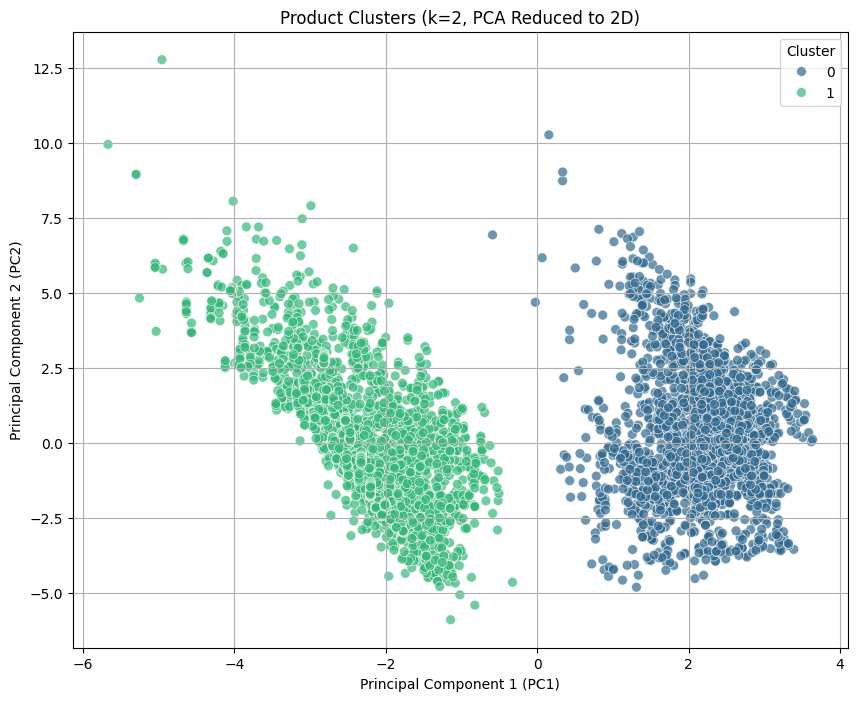

In [6]:
if df_pca_k2 is not None and 'cluster_labels_k2' in locals():
    df_pca_k2['cluster'] = cluster_labels_k2

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca_k2, palette='viridis', s=50, alpha=0.7)
    plt.title(f'Product Clusters (k={chosen_k}, PCA Reduced to 2D)')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()
else:
    print("PCA data or cluster labels not available for plotting by cluster.")

The scatter plot visually represents the two product clusters (k=2) after dimensionality reduction using PCA. Cluster 0 (blue) and Cluster 1 (green) are plotted based on their first two principal components. The clusters appear reasonably well-separated in this 2D projection, with Cluster 0 occupying the right side of the plot and Cluster 1 on the left. Both clusters exhibit a somewhat dispersed, cloud-like structure. Cluster 0 seems to be more densely packed in its core region compared to Cluster 1, which appears a bit more elongated along the PC2 axis and spread out. There isn't significant overlap between the main bodies of the two clusters, which supports the earlier observation from the metrics that the model identifies two distinct groups, even if the boundaries aren't perfectly crisp.


Number of unique 'tipo_de_producto' categories for PCA plot: 17


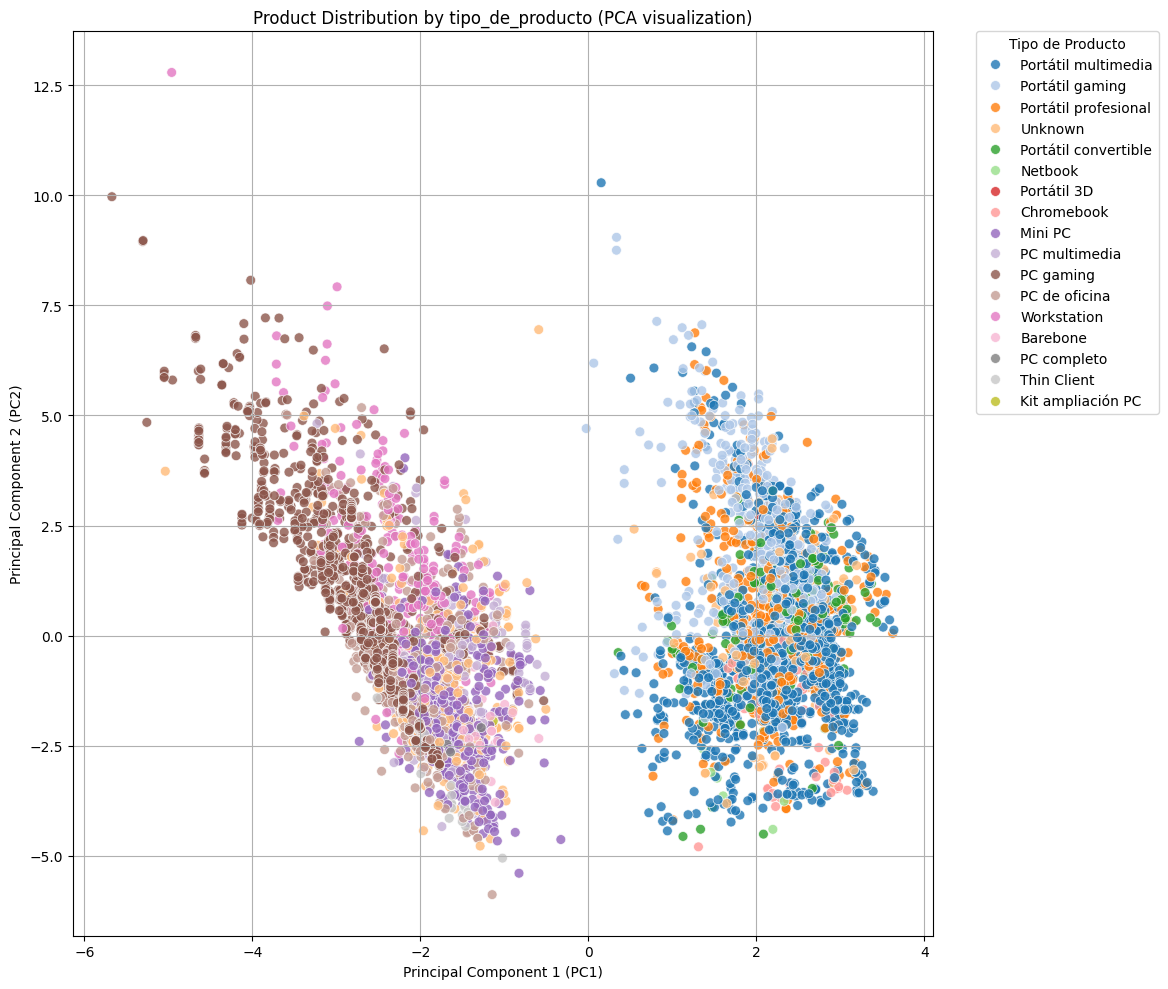

In [7]:
if df_pca_k2 is not None and 'df_clustered_k2' in locals():
    df_pca_k2['tipo_de_producto'] = df_clustered_k2['tipo_de_producto'].values

    unique_product_types_pca_k2 = df_pca_k2['tipo_de_producto'].nunique()
    print(f"\nNumber of unique 'tipo_de_producto' categories for PCA plot: {unique_product_types_pca_k2}")

    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='tipo_de_producto',
        data=df_pca_k2,
        palette='tab20' if unique_product_types_pca_k2 <= 20 else 'viridis',
        s=50,
        alpha=0.8,
        legend='auto'
    )
    plt.title('Product Distribution by tipo_de_producto (PCA visualization)')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')

    if unique_product_types_pca_k2 > 10:
        plt.legend(title='Tipo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        plt.legend(title='Tipo de Producto')

    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1] if unique_product_types_pca_k2 > 10 else [0,0,1,1])
    plt.show()
else:
    print("PCA data or original clustered data not available for plotting by tipo_de_producto.")


This PCA visualization effectively illustrates how the different tipo_de_producto categories are distributed across the two identified clusters. It's clear from the plot that the clustering has managed to group similar product types together. The cluster on the right side of the graph predominantly consists of various types of laptops (e.g., Portátil multimedia, Portátil gaming, Portátil profesional, Chromebook) and other portable devices like Mini PC. Conversely, the cluster on the left is largely composed of desktop computer categories (e.g., PC gaming, PC de oficina, Workstation, PC completo).

Crucially, the tipo_de_producto categories tend to remain within their respective clusters with minimal mixing. For instance, laptop categories are almost exclusively found in the right-hand cluster, and desktop PC categories are concentrated in the left-hand cluster. This indicates that the k-means algorithm, based on the selected features, has successfully identified and separated these overarching product distinctions, and the PCA visualization effectively showcases this separation in a lower-dimensional space.